In [1]:
from encoders import *
from decoders import *

In [4]:
# enter your image shape
IMAGE_SHAPE = (1, 28, 28)


In [6]:
encoder = Encoder28x28()
output = encoder(torch.randn(10, *IMAGE_SHAPE))
print(f"Encoder output shape: {output.shape}")
print(f"Encoder output range: {output.min()}, {output.max()}")

Encoder output shape: torch.Size([10, 32, 3, 3])
Encoder output range: 0.0, 4.284663677215576


In [4]:
LATENT_SHAPE = (128, 1, 1)
decoder = OmniglotDecoder()
output = decoder(torch.randn(10, *LATENT_SHAPE))
print(f"Encoder output shape: {output.shape}")

Encoder output shape: torch.Size([10, 1, 28, 28])


In [62]:
# create a tensor of shape (10, 512) range from -26 to 26
x = torch.randn(10, 512) * 20
print(f"x has range: {x.min()} to {x.max()}")

x has range: -64.39373779296875 to 70.6744384765625


In [70]:
import math
ll = nn.Linear(512, 512)
# Calculate the initialization range
init_range = 1e-3

# Initialize weights uniformly in [-init_range, init_range]
nn.init.uniform_(ll.weight, -init_range, init_range)

# Initialize biases uniformly in [-1/sqrt(fan_in), 1/sqrt(fan_in)]
if ll.bias is not None:
    nn.init.uniform_(ll.bias, -1e-3, 1e-3)

y = ll(x)

print(f"y has range: {y.min()} to {y.max()}")
print(f"exp(0.5 * y) has range: {torch.exp(0.5 * y).min()} to {torch.exp(0.5 * y).max()}")

y has range: -1.0449903011322021 to 0.8784927129745483
exp(0.5 * y) has range: 0.5930389761924744 to 1.5515375137329102


In [1]:
import torch

In [5]:
torch.nn.Parameter(torch.full((1,), 0)[0], requires_grad=False)

Parameter containing:
tensor(0)

In [10]:
torch.nn.Parameter(torch.zeros(1)[0])

Parameter containing:
tensor(0., requires_grad=True)

In [2]:
import utils

In [7]:
for i in range(20):
    print(utils.get_loss_weights(i, recon_intv=0, dkl_intv=10, start_first='dkl'))

(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 1)
(1, 0)
(1, 0)
(1, 0)
(1, 0)
(1, 0)
(1, 0)
(1, 0)
(1, 0)
(1, 0)
(1, 0)


In [8]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

In [69]:
# Define Gaussian PDF
def gaussian_pdf(x, mu, var):
    return 1 / np.sqrt(2 * np.pi * var) * np.exp(- (x - mu)**2 / (2 * var))

# calculate the KL divergence
def kl_divergence(mu1, var1, mu2, var2):
    return np.log(var2 / var1) + (var1 + (mu1 - mu2)**2) / (2 * var2) - 0.5


Split ratio: 0.9734050962890877


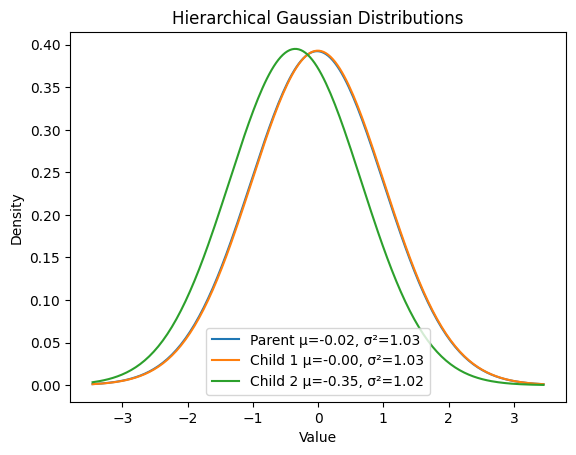

DKL between child 1 and child 2: 0.001621188233023707
DKL between child 2 and child 1: 0.06083589616865903


In [73]:
data = np.random.randn(1000)

# Compute parent mean and variance
mu_parent = np.mean(data)
var_parent = np.var(data)

# Random split weight and clustering
p = np.random.rand()  # random split ratio
print(f"Split ratio: {p}")
mask = np.random.rand(len(data)) < p
# print(f"Mask: {mask}")  
cluster1 = data[mask]
cluster2 = data[~mask]

# Compute children's mean and variance
mu1, var1 = np.mean(cluster1), np.var(cluster1)
mu2, var2 = np.mean(cluster2), np.var(cluster2)

# Gaussian PDF definition
def gaussian_pdf(x, mu, var):
    return 1 / np.sqrt(2 * np.pi * var) * np.exp(- (x - mu)**2 / (2 * var))

# Generate x-values for plotting
x = np.linspace(min(data), max(data), 200)
pdf_parent = gaussian_pdf(x, mu_parent, var_parent)
pdf1 = gaussian_pdf(x, mu1, var1)
pdf2 = gaussian_pdf(x, mu2, var2)

# Plot parent and child Gaussian PDFs
plt.figure()
plt.plot(x, pdf_parent, label=f'Parent μ={mu_parent:.2f}, σ²={var_parent:.2f}')
plt.plot(x, pdf1,      label=f'Child 1 μ={mu1:.2f}, σ²={var1:.2f}')
plt.plot(x, pdf2,      label=f'Child 2 μ={mu2:.2f}, σ²={var2:.2f}')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Hierarchical Gaussian Distributions')
plt.legend()
plt.show()

# print dkl between two children
dkl1 = kl_divergence(mu1, var1, mu_parent, var_parent)
dkl2 = kl_divergence(mu2, var2, mu_parent, var_parent)
print(f"DKL between child 1 and child 2: {dkl1}")
print(f"DKL between child 2 and child 1: {dkl2}")

# print 

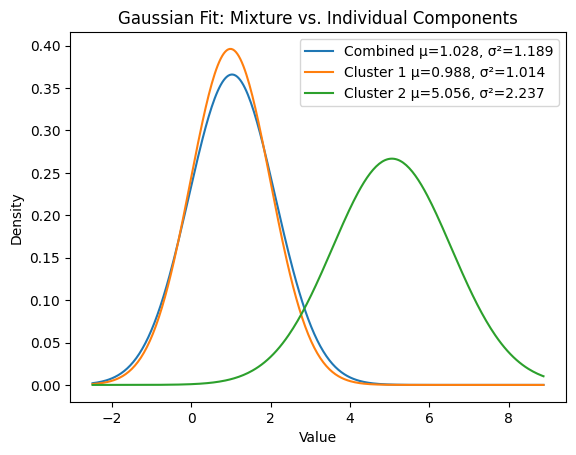

In [87]:
# Generate two synthetic 1-D distributions
n1, n2 = 10000, 100
mu1_true, var1_true = 1, 1
mu2_true, var2_true = 5, 2
data1 = np.random.normal(mu1_true, np.sqrt(var1_true), n1)
data2 = np.random.normal(mu2_true, np.sqrt(var2_true), n2)
data = np.concatenate([data1, data2])

# Compute empirical means and variances
mu_all, var_all = np.mean(data), np.var(data)
mu1_emp, var1_emp = np.mean(data1), np.var(data1)
mu2_emp, var2_emp = np.mean(data2), np.var(data2)

# Gaussian PDF function
def gaussian_pdf(x, mu, var):
    return 1 / np.sqrt(2 * np.pi * var) * np.exp(- (x - mu)**2 / (2 * var))

# Prepare x-axis
x = np.linspace(min(data), max(data), 300)
pdf_all = gaussian_pdf(x, mu_all, var_all)
pdf1 = gaussian_pdf(x, mu1_emp, var1_emp)
pdf2 = gaussian_pdf(x, mu2_emp, var2_emp)

# Plot all three Gaussian PDFs
plt.figure()
plt.plot(x, pdf_all, label=f'Combined μ={mu_all:.3f}, σ²={var_all:.3f}')
plt.plot(x, pdf1,      label=f'Cluster 1 μ={mu1_emp:.3f}, σ²={var1_emp:.3f}')
plt.plot(x, pdf2,      label=f'Cluster 2 μ={mu2_emp:.3f}, σ²={var2_emp:.3f}')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Gaussian Fit: Mixture vs. Individual Components')
plt.legend()
plt.show()

In [88]:
# dkl between two children
dkl1 = kl_divergence(mu1_emp, var1_emp, mu2_emp, var2_emp)
# dkl between two children
dkl2 = kl_divergence(mu2_emp, var2_emp, mu1_emp, var1_emp)
print(f"KL divergence between child 1 and child 2: {dkl1}")
print(f"KL divergence between child 2 and child 1: {dkl2}")
print(f"Sum of KL divergences: {dkl1 + dkl2}")

KL divergence between child 1 and child 2: 4.216525629148143
KL divergence between child 2 and child 1: 7.97032760951835
Sum of KL divergences: 12.186853238666494


In [61]:
0.5 * var2_emp + 0.5 * var1_emp + 0.5 * (mu1_emp - mu_all)**2 + 0.5 * (mu2_emp - mu_all)**2

np.float64(5.573813516696156)

In [59]:
var_all

np.float64(5.573813516696158)

In [3]:
import utils
import torch
import numpy as np
import matplotlib.pyplot as plt

In [18]:
train_loader, test_loader, train_set, test_set = utils.get_data_loader('cifar-10', 128, False)

/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


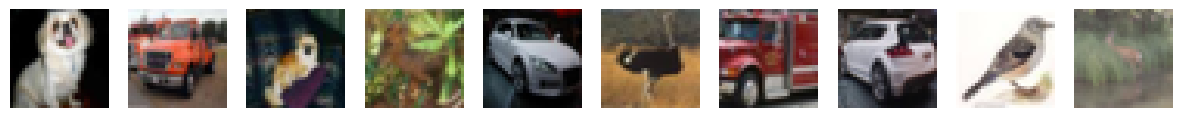

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1045735..1.8647997].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84250313..1.7602954].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.98201126..1.5193145].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0192187..1.7178177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0553108..1.5371423].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9280347..1.5737015].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7967

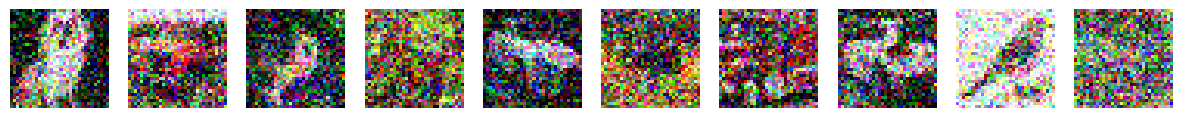

In [32]:
for i, (x, y) in enumerate(train_loader):
    # display first 10 images in the batch in a row
    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for j in range(10):
        axes[j].imshow(x[j].permute(1, 2, 0).numpy())
        axes[j].axis('off')
    plt.show()

    # add noise:
    x_noisy = utils.add_noise(x, 0.3, 'gaussian')
    # display first 10 images in the batch in a row
    fig, axes = plt.subplots(1, 10, figsize=(15, 2))
    for j in range(10):
        axes[j].imshow(x_noisy[j].permute(1, 2, 0).numpy())
        axes[j].axis('off')
    plt.show()
    break

In [1]:
# test on ResNet-50 representation

In [17]:
import torch
import torch.nn as nn
import torchvision.models as models
import utils
from collections import OrderedDict


In [2]:
train_loader, test_loader, train_set, test_set = utils.get_data_loader('stl-10', 128, False)

/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [36]:
for i, (x, y) in enumerate(test_loader):
    print(f"Batch {i}:")
    print(f"  x shape: {x.shape}")
    print(f"  y shape: {y.shape}")
    print(y)
    break

Batch 0:
  x shape: torch.Size([1024, 3, 96, 96])
  y shape: torch.Size([1024])
tensor([6, 7, 5,  ..., 8, 9, 2])


In [26]:
checkpoint_path = '/nethome/zwang910/file_storage/nips-2025/deep-taxon/pretrained/'
model_name = 'checkpoint_0040.pth.tar'
# Determine device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
cpt = torch.load(checkpoint_path + model_name, map_location=device)
cpt

Using device: cuda


{'epoch': 40,
 'arch': 'resnet50',
 'state_dict': OrderedDict([('backbone.conv1.weight',
               tensor([[[[ 7.3281e-03, -3.0607e-03, -2.5822e-02,  ..., -3.3968e-03,
                           1.2385e-02,  1.2714e-02],
                         [ 7.6321e-02,  1.2351e-01,  5.0131e-02,  ...,  3.8313e-02,
                           5.3782e-02,  1.0554e-01],
                         [ 7.3154e-02,  7.4880e-02,  4.0240e-02,  ...,  1.3395e-02,
                           4.5244e-02,  4.4676e-02],
                         ...,
                         [ 2.7975e-02,  5.2430e-02,  4.2675e-02,  ...,  1.7895e-02,
                          -1.9097e-02,  2.3770e-02],
                         [ 5.4918e-03,  3.6791e-02,  3.4679e-03,  ..., -7.5872e-03,
                           3.7640e-04,  2.9778e-02],
                         [-1.9117e-02,  4.8063e-02,  1.1564e-02,  ..., -4.5103e-02,
                           2.5148e-02, -1.8508e-03]],
               
                        [[ 8.7424e-03,  2.

In [27]:
model = models.resnet50(pretrained=False)
# --- 2. Load the Checkpoint File ---
print(f"Loading checkpoint from: {checkpoint_path}")
# Load onto CPU first to make key inspection and processing easier
checkpoint = torch.load(checkpoint_path + model_name, map_location=device)

# --- 3. Extract and Process the State Dictionary ---
if 'state_dict' not in checkpoint:
    # If 'state_dict' is not found, maybe the checkpoint *is* the state_dict
    if isinstance(checkpoint, dict):
         print("Warning: Checkpoint does not contain 'state_dict' key. Assuming the loaded object IS the state_dict.")
         original_state_dict = checkpoint
    else:
        raise KeyError(f"Checkpoint does not seem to be a dictionary or contain the key 'state_dict'. Found type: {type(checkpoint)}")
else:
    original_state_dict = checkpoint['state_dict']
    print("Extracted state_dict from checkpoint.")

# *** CRITICAL STEP: Determine the correct prefix to remove ***
# Inspect the keys of your specific checkpoint file to find the correct prefix.
# Common prefixes for SimCLR models trained with distributed training:
# 'module.encoder.', 'module.backbone.', 'encoder.', 'backbone.'
# Uncomment the next line to print the first few keys and check:
# print("First 10 keys from checkpoint state_dict:", list(original_state_dict.keys())[:10])

prefix_to_remove = "backbone." # <--- ADJUST THIS BASED ON YOUR INSPECTION!
print(f"Attempting to remove prefix: '{prefix_to_remove}'")

new_state_dict = OrderedDict()
keys_matched = 0
keys_unmatched_printed = 0
for k, v in original_state_dict.items():
    if k.startswith(prefix_to_remove):
        # Remove the prefix to match the standard ResNet-50 key names
        name = k[len(prefix_to_remove):]
        new_state_dict[name] = v
        keys_matched += 1
    else:
        # Keep track of keys that didn't match the prefix, might be projection head etc.
        if keys_unmatched_printed < 5: # Print first few unmatched keys
            print(f"  - Key '{k}' did not match prefix, skipping for standard ResNet load.")
            keys_unmatched_printed +=1
        elif keys_unmatched_printed == 5:
            print("  - (Further unmatched keys omitted)...")
            keys_unmatched_printed += 1
        # You could choose to add non-prefixed keys if needed, but for loading
        # into standard ResNet, we usually only want the backbone weights.
        # new_state_dict[k] = v # Uncomment this line if you expect non-prefixed keys to also be loaded

if keys_matched == 0:
    print(f"\nWARNING: No keys matched the prefix '{prefix_to_remove}'.")
    print("Please MANUALLY INSPECT the keys in your checkpoint and adjust `prefix_to_remove`.")
    print("Checkpoint keys sample:", list(original_state_dict.keys())[:10])
    # If you are sure there's no prefix, you might comment out the processing loop
    # and use: new_state_dict = original_state_dict
else:
    print(f"Processed {keys_matched} keys by removing prefix '{prefix_to_remove}'")


# --- 4. Load the Processed State Dictionary into the Model ---
print("Loading processed state_dict into the ResNet-50 model...")

# Use strict=False. This is important because:
#  - The SimCLR state_dict usually contains only the backbone weights, lacking the final 'fc' layer of the standard ResNet.
#  - The original SimCLR checkpoint might contain weights for a projection head (e.g., 'projector.fc1.weight') which are not in the standard ResNet.
# `strict=False` allows loading the weights that *do* match, ignoring the missing 'fc' keys and unexpected projection head keys.
load_result = model.load_state_dict(new_state_dict, strict=False)

# Report missing/unexpected keys to understand what was loaded
print("\n--- Load State Dict Results ---")
if not load_result.missing_keys:
    print("  - No missing keys.")
else:
    print(f"  - Missing keys ({len(load_result.missing_keys)}): {load_result.missing_keys}")
    if 'fc.weight' in load_result.missing_keys or 'fc.bias' in load_result.missing_keys:
        print("     (INFO: Missing 'fc.weight'/'fc.bias' is expected as SimCLR checkpoint contains backbone weights).")

if not load_result.unexpected_keys:
    print("  - No unexpected keys.")
else:
    print(f"  - Unexpected keys ({len(load_result.unexpected_keys)}): {load_result.unexpected_keys}")
    print("     (INFO: Unexpected keys might correspond to SimCLR projection head layers not present in standard ResNet).")
print("--- End Load State Dict Results ---")


# --- Final Steps ---
# Move the model to the appropriate device
model.to(device)

# Set the model to evaluation mode (disables dropout, uses running stats for BatchNorm)
model.eval()

print(f"\nSuccessfully loaded weights into model = models.resnet50(pretrained=False/weights=None).")
print(f"Model is on device '{device}' and in evaluation mode.")

/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading checkpoint from: /nethome/zwang910/file_storage/nips-2025/deep-taxon/pretrained/
Extracted state_dict from checkpoint.
Attempting to remove prefix: 'backbone.'
Processed 322 keys by removing prefix 'backbone.'
Loading processed state_dict into the ResNet-50 model...

--- Load State Dict Results ---
  - Missing keys (2): ['fc.weight', 'fc.bias']
     (INFO: Missing 'fc.weight'/'fc.bias' is expected as SimCLR checkpoint contains backbone weights).
  - Unexpected keys (4): ['fc.0.weight', 'fc.0.bias', 'fc.2.weight', 'fc.2.bias']
     (INFO: Unexpected keys might correspond to SimCLR projection head layers not present in standard ResNet).
--- End Load State Dict Results ---

Successfully loaded weights into model = models.resnet50(pretrained=False/weights=None).
Model is on device 'cuda' and in evaluation mode.


In [30]:
# remove the fc head
model.conv1.weight

Parameter containing:
tensor([[[[ 7.3281e-03, -3.0607e-03, -2.5822e-02,  ..., -3.3968e-03,
            1.2385e-02,  1.2714e-02],
          [ 7.6321e-02,  1.2351e-01,  5.0131e-02,  ...,  3.8313e-02,
            5.3782e-02,  1.0554e-01],
          [ 7.3154e-02,  7.4880e-02,  4.0240e-02,  ...,  1.3395e-02,
            4.5244e-02,  4.4676e-02],
          ...,
          [ 2.7975e-02,  5.2430e-02,  4.2675e-02,  ...,  1.7895e-02,
           -1.9097e-02,  2.3770e-02],
          [ 5.4918e-03,  3.6791e-02,  3.4679e-03,  ..., -7.5872e-03,
            3.7640e-04,  2.9778e-02],
          [-1.9117e-02,  4.8063e-02,  1.1564e-02,  ..., -4.5103e-02,
            2.5148e-02, -1.8508e-03]],

         [[ 8.7424e-03,  2.2194e-02,  2.8380e-03,  ..., -2.2463e-02,
            1.1107e-02, -1.0925e-02],
          [ 3.7056e-02,  4.3812e-02,  7.3205e-02,  ...,  4.8996e-02,
            4.4131e-02,  5.9439e-02],
          [ 6.0042e-02,  1.2059e-01,  3.1042e-02,  ...,  4.2988e-03,
            4.4507e-02,  2.9307e-02]

In [31]:
model_ = models.resnet50(pretrained=False)
model_.conv1.weight

/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Parameter containing:
tensor([[[[-1.5213e-02, -1.0914e-02, -2.8553e-02,  ..., -1.7251e-03,
            1.4648e-02,  4.2147e-03],
          [-4.7590e-02,  6.9285e-03, -1.0070e-02,  ...,  2.4596e-02,
            2.5962e-04,  2.8716e-02],
          [ 3.8496e-02,  2.9427e-03,  2.2803e-02,  ...,  9.0601e-02,
           -1.6223e-02, -1.6191e-02],
          ...,
          [ 1.2159e-02, -1.4709e-02,  1.4058e-02,  ...,  4.0210e-03,
            8.6061e-03,  5.3715e-03],
          [ 2.3181e-02, -2.4077e-03,  9.5741e-03,  ...,  9.2874e-03,
            1.4849e-02,  7.1703e-03],
          [ 4.2368e-03,  2.3410e-02,  2.7790e-02,  ..., -3.7744e-02,
           -1.6577e-02,  1.1397e-02]],

         [[ 3.8905e-02,  1.8690e-02, -2.9918e-02,  ...,  2.4004e-02,
           -2.1804e-02,  3.4039e-02],
          [ 3.6029e-02, -5.1062e-02, -3.1574e-02,  ...,  3.9256e-02,
            1.0711e-02, -3.3644e-02],
          [ 2.1132e-02, -6.7476e-02, -2.0939e-02,  ..., -4.1998e-02,
           -2.0168e-02, -2.9534e-02]

In [25]:
for i, (x, y) in enumerate(train_loader):
    print(f"Batch {i}:")
    print(f"  x shape: {x.shape}")
    print(f"  y shape: {y.shape}")
    # print(y)
    # break
    # get the representation
    x = model(x.to(device))
    print(f"  x shape: {x.shape}")
    break

Batch 0:
  x shape: torch.Size([128, 3, 96, 96])
  y shape: torch.Size([128])
  x shape: torch.Size([128, 2048])
